In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from copy import deepcopy
%matplotlib inline

# 【問題2】1次元畳み込み後の出力サイズの計算

$$
N_{out} = \frac{N_{in}+2P-F}{S}+1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ



In [2]:
def calc_out_shape(n_in, fill_size, pad=0, stride=1):
    n_out = (n_in + 2*pad - fill_size) / stride + 1
    return n_out

# 【問題１】チャンネル数の1に限定した一次元畳み込み層のクラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。


$$a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b$$

𝑎𝑖 : 出力される配列のi番目の値


𝐹 : フィルタのサイズ


𝑥(𝑖+𝑠) : 入力の配列の(i+s)番目の値


𝑤𝑠 : 重みの配列のs番目の値


𝑏 : バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。


$$w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}$$

𝛼 : 学習率


∂𝐿∂𝑤𝑠 : 𝑤𝑠 に関する損失 𝐿 の勾配


∂𝐿∂𝑏 : 𝑏 に関する損失 𝐿 の勾配


勾配 ∂𝐿∂𝑤𝑠 や ∂𝐿∂𝑏 を求めるためのバックプロパゲーションの数式が以下です。


$$\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}$$

∂𝐿∂𝑎𝑖 : 勾配の配列のi番目の値


𝑁𝑜𝑢𝑡 : 出力のサイズ


前の層に流す誤差の数式は以下です。


$$\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s$$

∂𝐿∂𝑥𝑗 : 前の層に流す誤差の配列のj番目の値


ただし、 𝑗−𝑠<0 または 𝑗−𝑠>𝑁𝑜𝑢𝑡−1 のとき ∂𝐿∂𝑎(𝑗−𝑠)=0 です。


全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

In [3]:
class CNN_1d_:
    def __init__(self, initializer, optimizer, layer):
        self.B = initializer.B()
        self.W = initializer.W()
        self.optimizer = optimizer
        self.layer = layer
        
        pass
    
    def forward(self, X):
        self.n_out = calc_out_shape(X.shape[0], W.shape[0]) #出力データ数
        
        self.in_data = np.array([X[n:n+W.shape[0]] for n in range(self.n_out)]) #Xを2次元の行列に加工する
        
        A = self.in_data @ self.W.T + self.B #forwardの計算
        
        return A
    
    
    def backward(self, dA):
        dB = np.sum(dA)
        dW = self.in_data.T @ dA
        
        
        dX = []
        for j in range(len(X)):
            dX_j = []
            for s in range(len(self.W)):
                if j - s < 0 or j -s > self.n_out - 1:
                    dX_j.append(0)
                else:
                    dX_j.append(dA[j - s] * self.W[s])
                    
            dX.append(sum(dX_j))
        
        dX = np.array(dX)
        
        return dX

# 【問題3】小さな配列での1次元畳み込み層の実験

フォワードプロパゲーションでは入力とパラメータが以下のようになっているとき

In [4]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

出力はこうなっているはずです
```python
a = np.array([35, 50])
```

In [5]:
def forward(X, W, B):
    n_out = int(calc_out_shape(len(X), len(W), pad=0, stride=1))
    n_out = int(calc_out_shape(X.shape[0], W.shape[0])) #出力データ数
    in_data = np.array([X[n:n+W.shape[0]] for n in range(n_out)]) #Xを2次元の行列に加工する
    A = in_data @ W.T + B #forwardの計算

    return A

forward(x, w, b)

array([35, 50])

バックプロパゲーションで誤差が以下のようなとき

In [6]:
delta_a = np.array([10, 20])

```python
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])
```
と、このようになります。

In [7]:
def backward(dA, X, W, B):
    n_out = int(calc_out_shape(len(X), len(W), pad=0, stride=1))
    
    dB = np.sum(dA)
    
    in_data = np.array([X[n:n+W.shape[0]] for n in range(n_out)])
    dW = in_data.T @ dA

    dX = []
    for j in range(len(X)):
        dX_j = []
        for s in range(len(W)):
            if j - s < 0 or j -s > n_out - 1:
                dX_j.append(0)
            else:
                dX_j.append(dA[j - s] * W[s])

        dX.append(sum(dX_j))

    dX = np.array(dX)

    return dB, dW, dX

backward(delta_a, x, w, b)

(30, array([ 50,  80, 110]), array([ 30, 110, 170, 140]))

## forward、back共に問題無し。

# 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

問題３と同じく出力を確認しましょう。

フォワードプロパゲーションでは入力とパラメータが以下のようになっているとき

In [8]:
X = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

```python
a = np.array([[16, 22], [17, 23], [18, 24]])
```

となっていれば正解です。

In [9]:
X = X.reshape(1, 2, 4)
X

array([[[1, 2, 3, 4],
        [2, 3, 4, 5]]])

### CNN1dクラスよりforward抜粋

In [10]:
def forward(X, W, B, stride):
    """
    X : 次の形のndarray, shape (batch_size, n_in_ch, n_features)

    W : 次の形のndarray, shape (n_out_ch, n_in_ch, fillter_size)

    """
    n_out = int(calc_out_shape(X.shape[2], W.shape[2], pad=0, stride=1))

    A = [] #batch_size毎のデータ
    for k in range(X.shape[0]):
        out_data = [] #n_out_ch毎のデータ
        for j in range(W.shape[0]):
            in_data_w = []
            for i in range(X.shape[1]): #Xをチャンネル毎に加工する
                in_data = np.array([X[k][i][n*stride : n*stride + W.shape[2]] for n in range(n_out)]) #２次元に加工
                in_data_w.append(in_data @ W[j][i].T) #重みを掛けてリストへ格納

            out_data_1ch = np.array(in_data_w).sum(axis=0) + B[j] #入力チャンネル分を合計してバイアスを足す
            out_data.append(out_data_1ch)
        A.append(out_data) #リストへ格納

    A = np.array(A)

    return A

forward(X, w, b, 1)

array([[[16., 22.],
        [17., 23.],
        [18., 24.]]])

## 問題無し。

In [11]:
class CNN1d:
    def __init__(self, n_in_ch, n_fillter, fillter_size, n_out, initializer, optimizer, layer):
        self.n_in_ch = n_in_ch
        self.n_out = n_out
        self.B = initializer.B(n_fillter)
        self.W = initializer.W(n_in_ch, n_fillter, fillter_size)
        self.HB = 0
        self.HW = 0
        self.optimizer = optimizer
        self.layer = layer
    
    def forward(self, X):
        """
        X : 次の形のndarray, shape (batch_size, n_in_ch, n_features)
        
        W : 次の形のndarray, shape (n_out_ch, n_in_ch, fillter_size)
        
        """
        self.X = X
        
        #【問題5】（アドバンス課題）パディングの実装　（前後ゼロパディング処理）
        X_pad = np.pad(X, [(0,0), (0,0), (self.layer.n_pad, self.layer.n_pad)], 'constant', constant_values=0)

        #【問題7】（アドバンス課題）任意のストライド数
        
        self.in_data_back = []
        
        A = [] #batch_size毎のデータ
        for k in range(X_pad.shape[0]):
            out_data = [] #n_out_ch毎のデータ
            for j in range(self.W.shape[0]):
                in_data_w = []
                for i in range(X_pad.shape[1]): #Xをチャンネル毎に加工する
                    in_data = np.array([X_pad[k][i][n*self.layer.stride : n*self.layer.stride + self.W.shape[2]] for n in range(self.n_out)]) #２次元に加工
                    in_data_w.append(in_data @ self.W[j][i].T) #重みを掛けてリストへ格納
                    self.in_data_back.append(in_data)

                out_data_1ch = np.array(in_data_w).sum(axis=0) + self.B[j] #入力チャンネル分を合計してバイアスを足す
                out_data.append(out_data_1ch)
            A.append(out_data) #リストへ格納

        self.in_data = in_data
        A = np.array(A)
   
        return A
    
    def backward(self, dA):
        dB = np.sum(np.sum(dA, axis=2), axis=0) / self.layer.batch_size
        
        #dWの処理
        in_data = self.in_data_back[0:self.X.shape[1]]
        dW = []
        for k in range(self.X.shape[0]):
            dW_out = []
            for j in range(self.W.shape[0]):#出力チャンネル毎に処理
                dW_1out = [] #出力１チャンネル分のdW
                for i in range(self.X.shape[1]): #入力チャンネル毎に処理
                    dW_1out.append(in_data[i].T @ dA[k][j]) #重みを掛けてリストへ格納    
                dW_out.append(dW_1out)
            dW.append(dW_out) #dWリストへ格納      
        
        dW = np.array(dW).sum(axis=0) / self.layer.batch_size
        
        #dXの処理
        dX_batch = [] #batch_size毎のデータ
        for x0 in range(self.X.shape[0]):
            dX_out_ch = [] #n_out_ch毎のデータ
            for out_ch in range(self.W.shape[0]):
                dX_in_ch = [] #n_in_ch毎のデータ
                for in_ch in range(self.X.shape[1]):
                    dX_row = []
                    for j in range(self.X.shape[2]):
                        dX_j = []
                        for s in range(self.W.shape[2]):
                            if j - s < 0 or j -s > self.n_out - 1:
                                dX_j.append(0)
                            else:
                                dX_j.append(dA[x0][in_ch][j - s] * self.W[out_ch][in_ch][s])
                        dX_row.append(sum(dX_j))
                    dX_in_ch.append(dX_row)
                dX_out_ch.append(dX_in_ch)
            one_sample = np.array(dX_out_ch).sum(axis=0)
            dX_batch.append(one_sample)  
            
        dX = np.array(dX_batch)
        
        self.dB = dB
        self.dW = dW
        
        # 更新
        if self.layer.optimizer == "SGD":
            self.B, self.W = self.optimizer.update(self)
        elif self.layer.optimizer == "AdaGrad":
            self.B, self.W, self.HB, self.HW = self.optimizer.update(self)

        return dX

# 【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。


最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。


フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。

# 【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

# 【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

# 問題５〜７の回答はCNN1dクラス及びScratch1dCNNClassifierクラス内に記載

# 【問題8】学習と推定

これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。


出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。


画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [12]:
class Flatten:
    def __init__(self):
        pass    
       
    def forward(self, X):
        """
        X : 次の形のndarray, shape (batch_size, n_in_ch, n_features)
        
        """
        self.X = X
        
        flatten_f = X.reshape(X.shape[0], -1)
        
        return flatten_f
    
    def backward(self,dA):
        """
        dA : 次の形のndarray, shape (batch_size, n_features)
        
        """
        flatten_b = dA.reshape(self.X.shape[0], -1, self.X.shape[2])
        
        return flatten_b

In [13]:
#Full Connected Layer Class
class FC:
    """
   全結合層
    Parameters
    ----------
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, layer):
        self.optimizer = optimizer
        self.layer = layer 
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.B = initializer.B(n_nodes2)
        self.W = initializer.W(n_nodes1, n_nodes2, None)
        
        self.HB = 0
        self.HW = 0
        
    def forward(self, X): #X or Z
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X #X or Z

        A = X @ self.W + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dB = np.sum(dA, axis=0) / self.layer.batch_size
        dW = self.X.T @ dA / self.layer.batch_size
        dZ = dA @ self.W.T
        
        self.dB = dB
        self.dW = dW
        

        # 更新
        if self.layer.optimizer == "SGD":
            self.B, self.W = self.optimizer.update(self)
        elif self.layer.optimizer == "AdaGrad":
            self.B, self.W, self.HB, self.HW = self.optimizer.update(self)
            
        return dZ

In [14]:
#Xavierの初期値
class XavierInitializer:
    def W(self, n_in, n_out, fillter_size):
        sigma = 1/np.sqrt(n_in)
        if fillter_size == None:
            W = sigma * np.random.randn(n_in, n_out) #重みの初期値(全結合層)
        else:
            W = sigma * np.random.randn(n_out, n_in, fillter_size) #重みの初期値（畳み込み層）
        return W

    def B(self, n_out):
        sigma = 1/np.sqrt(n_out)
        B = sigma * np.random.randn(n_out) #バイアスの初期値
        return B

In [15]:
#Heの初期値
class HeInitializer:
    def W(self, n_in, n_out, fillter_size):
        sigma = np.sqrt(2/n_in)
        if fillter_size == None:
            W = sigma * np.random.randn(n_in, n_out) #重みの初期値(全結合層)
        else:
            W = sigma * np.random.randn(n_out, n_in, fillter_size) #重みの初期値（畳み込み層）
        return W
    
    def B(self, n_out):
        sigma = np.sqrt(2/n_out)
        B = sigma * np.random.randn(n_out) #バイアスの初期値
        return B

In [16]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        B = layer.B - (self.lr * layer.dB) 
        W = layer.W - (self.lr * layer.dW)
        
        return B, W

In [17]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        HB = layer.HB + layer.dB**2
        B = layer.B - (self.lr * (1/(np.sqrt(HB) + 1e-7)) * layer.dB)

        HW = layer.HW + layer.dW**2
        W = layer.W - (self.lr * (1/(np.sqrt(HW) + 1e-7)) * layer.dW)
        
        return B, W, HB, HW

In [18]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        Z = 1 / (1 + np.exp(-A)) #シグモイド関数
        self.A = A
        return Z
    
    def backward(self, dZ):
        dA = dZ * ((1 - (1 / (1 + np.exp(-self.A)))) * (1 / (1 + np.exp(-self.A)))) #Aに関する損失の勾配
        return dA 

In [19]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        Z = np.tanh(A) #ハイパボリックタンジェント関数
        self.A = A
        return Z
    
    def backward(self, dZ):
        dA = dZ * (1 - np.tanh(self.A)**2) #Aに関する損失の勾配
        return dA 

In [20]:
class ReLU:
    def __init__(self):
        self.mask = None
        pass
    
    def forward(self, A):
        Z = np.maximum(0 + 1e-7, A)
        self.mask = (Z <= 0 + 1e-7)
        return Z 
    
    def backward(self, dZ):
        dZ[self.mask] = 0 + 1e-7
        dA = dZ 
        return dA

In [21]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, A):
        A = A - np.max(A, axis=1, keepdims=True) #オーバーフロー対策
        Z = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True) #ソフトマックス関数
        return Z
    
    def backward(self, Z, Y):
        dA = Z - Y  #Aに関する損失の勾配
        loss = -1 * np.sum(Y * np.log(Z + 1e-7)) / Z.shape[0] #交差エントロピー誤差

        return dA, loss

In [22]:
class Scratch1dCNNClassifier:
    def __init__(self, lr=10**-2, batch_size=20, activation_func="Tanh", optimizer="AdaGrad", 
                            n_pad=1, stride=2, fillter_size=3, n_fillter1=5, n_fillter2=10, n_epoch=1, verbose = False):
        
        self.lr = lr #学習率
        self.batch_size = batch_size #バッチサイズ
        self.activation_func = activation_func #活性化関数の種類
        self.optimizer = optimizer #最適化手法
        self.n_pad = n_pad #パディング数
        self.stride = stride #ストライド数
        self.fillter_size = fillter_size #フィルターサイズ
        self.n_fillter1 = n_fillter1 #1層目フィルター数
        self.n_fillter2 = n_fillter2 #2層目フィルター数
        self.n_epoch =n_epoch #エポック数
        self.loss_list = [] #損失を記録するリスト
        self.loss_list_val = [] #損失を記録するリスト(検証データ用)
        self.verbose = verbose
        
    def calc_out_shape(self, n_in, fillter_size, n_pad, stride):
        n_out = int((n_in + 2*n_pad - fillter_size) / stride + 1)
        return n_out
    
    def fit(self, X, y, X_val=None, y_val=None, cnt = 1):
        X = X.reshape(X.shape[0], -1, X.shape[1]) #2次元→3次元データへreshape(サンプル数 :48000、チャンネル数 :1、特徴量数 :784)
        self.n_features = X.shape[2]
        self.n_in_ch = X.shape[1]
        self.n_out1 = self.calc_out_shape(self.n_features, self.fillter_size, self.n_pad, self.stride)
        self.n_out2 = self.calc_out_shape(self.n_out1, self.fillter_size, self.n_pad, self.stride)
        self.n_output = y.shape[1]
        if self.optimizer == "SGD":
            optimizer = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer = AdaGrad(self.lr)
        if self.activation_func == "Tanh":
            activation = Tanh()
            initializer = XavierInitializer() #Xavierの初期値
        elif self.activation_func == "Sigmoid":
            activation = Sigmoid()
            initializer = XavierInitializer() #Xavierの初期値
        elif self.activation_func == "ReLU":
            activation = ReLU()
            initializer = HeInitializer() #Heの初期値
        self.CNN1d1 = CNN1d(self.n_in_ch, self.n_fillter1, self.fillter_size, self.n_out1, initializer, optimizer, self)
        self.activation1 = deepcopy(activation)
        self.CNN1d2 = CNN1d(self.n_fillter1, self.n_fillter2, self.fillter_size, self.n_out2, initializer, optimizer, self)
        self.activation2 = deepcopy(activation)
        self.Flatten = Flatten()
        self.FC3 = FC(self.n_out2*self.n_fillter2, self.n_output, initializer, optimizer, self)
        self.activation3 = Softmax()
         
        #fitを再帰させて学習データと検証データの両方を学習させる。検証データがあれば先に検証データを学習させる
        if X_val is None:
            get_mini_batch = GetMiniBatch(X, y, self.batch_size) #GetMiniBatchクラスでミニバッチを作成
        else:
            get_mini_batch = GetMiniBatch(X_val, y_val, self.batch_size) #GetMiniBatchクラスでミニバッチを作成
        
        #学習処理
        for i in range(self.n_epoch):
            loss_list = []
            for mini_X_train, mini_y_train in get_mini_batch:
                # このfor文内でミニバッチが使える

                #forwardの処理
                A1 = self.CNN1d1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.CNN1d2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                Z2_f = self.Flatten.forward(Z2)
                A3 = self.FC3.forward(Z2_f)
                Z3 = self.activation3.forward(A3)

                #backwardの処理
                dA3, loss = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dZ2_f = self.Flatten.backward(dZ2)
                dA2 = self.activation2.backward(dZ2_f)
                dZ1 = self.CNN1d2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.CNN1d1.backward(dA1) # dZ0は使用しない
                
                """
                Loss Curvを描くための処理
                """                
                loss_list.append(loss)

            
            if X_val is None:
                self.loss_list.append(np.mean(loss_list))
                if self.verbose: #verboseをTrueにした際は学習過程などを出力する
                    print(loss_list)
            else:
                self.loss_list_val.append(np.mean(loss_list))
                if self.verbose: #verboseをTrueにした際は学習過程などを出力する
                    print(loss_list_val)
                
        cnt += 1
        if cnt == 3 or X_val is None:
            return
        
        return self.fit(X, y, cnt = cnt) #検証データが入力されている場合は再帰させて学習データを学習させる。

    def predict(self,X):
        X = X.reshape(X.shape[0], -1, X.shape[1]) #2次元→3次元データへreshape(サンプル数 :48000、チャンネル数 :1、特徴量数 :784)
        A1 = self.CNN1d1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.CNN1d2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        Z2_f = self.Flatten.forward(Z2)
        A3 = self.FC3.forward(Z2_f)
        y = self.activation3.forward(A3)
        
        pred = np.argmax(y, axis=1)
        
        return pred

# データ準備

In [23]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

In [24]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [25]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [26]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [28]:
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
print(y_train_one_hot.shape)
print(y_val_one_hot.shape)

(48000, 10)
(12000, 10)


In [29]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [30]:
s1dc = Scratch1dCNNClassifier(lr=10**-1, batch_size=20, activation_func="ReLU", optimizer="AdaGrad", 
                            n_pad=1, stride=3, fillter_size=6, n_fillter1=2, n_fillter2=2, n_epoch=10, verbose = False)
s1dc.fit(X_train, y_train_one_hot)#, X_val, y_val_one_hot、計算に時間が掛かる為valは無し

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

In [32]:
#テストデータ
pred = s1dc.predict(X_test)
print(pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, pred)))
print("混同行列：")
print(confusion_matrix(y_test, pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, pred))

[7 2 1 ... 4 6 6]
正解率：0.83
混同行列：
[[ 899    1    9    6    5   18   26    2    6    8]
 [   1 1106    5    6    5    3    5    1    3    0]
 [  30   19  822   35   17    8   55   14   24    8]
 [   2    1   41  824   15   64   17   18   12   16]
 [  21    2   18   13  747   12   37   23   27   82]
 [  15    9   31   94   19  610   61    6   34   13]
 [  18    2   16    1   13   10  887    0   10    1]
 [   1   17   17    7   31   11    2  896    4   42]
 [  11    5   33  117   47   40   25   15  658   23]
 [  18    3    5   26   40    5    1   42   15  854]]
classification_report：
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       980
           1       0.95      0.97      0.96      1135
           2       0.82      0.80      0.81      1032
           3       0.73      0.82      0.77      1010
           4       0.80      0.76      0.78       982
           5       0.78      0.68      0.73       892
           6       0.79      0.93 

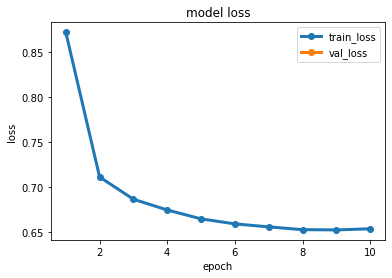

In [33]:
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, len(s1dc.loss_list)+1), s1dc.loss_list, label="train_loss", marker="o", linewidth=3)
plt.plot(np.arange(1, len(s1dc.loss_list_val)+1), s1dc.loss_list_val, label="val_loss", marker="o", linewidth=3)
plt.legend()
plt.show()

### １パターンのみだが、正解率は0.83となった。実装にfor文を多用してしまい計算速度がめちゃくちゃ遅くなってしまった為、複数回実施することが出来なかった。今後は、魚本の中にある「image to column」の考え方を実装に取り入れ、計算速度の向上を図って行きたい。